In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from google.colab.patches import cv2_imshow
import glob

In [3]:
#setup path
IMAGES_X_TRAIN_PATH = "drive/MyDrive/Colab Notebooks/CVProject3/images_prepped_train_clean/" #dir_x, # 367 images
IMAGES_X_TEST_PATH = "drive/MyDrive/Colab Notebooks/CVProject3/images_prepped_test/"

IMAGES_Y_TRAIN_PATH = "drive/MyDrive/Colab Notebooks/CVProject3/annotations_prepped_train/" #dir_y, # 101 images
IMAGES_Y_TEST_PATH = "drive/MyDrive/Colab Notebooks/CVProject3/annotations_prepped_test/"

images_train_filename = os.listdir(IMAGES_X_TRAIN_PATH)
images_test_filename = os.listdir(IMAGES_X_TEST_PATH)

In [4]:
print(images_train_filename)
print(images_test_filename)

['0006R0_f02850.png', '0016E5_07110.png', '0016E5_06720.png', '0016E5_01140.png', '0006R0_f02820.png', '0016E5_07770.png', '0006R0_f03450.png', '0016E5_00901.png', '0016E5_00450.png', '0016E5_00600.png', '0016E5_01830.png', '0006R0_f01380.png', '0006R0_f02640.png', '0016E5_01110.png', '0006R0_f02670.png', '0016E5_04350.png', '0016E5_00840.png', '0016E5_06630.png', '0016E5_07830.png', '0006R0_f02790.png', '0006R0_f01470.png', '0016E5_07230.png', '0016E5_00930.png', '0016E5_01050.png', '0006R0_f01290.png', '0001TP_008010.png', '0016E5_00990.png', '0016E5_01800.png', '0006R0_f01740.png', '0016E5_06360.png', '0016E5_04410.png', '0016E5_04650.png', '0016E5_07440.png', '0016E5_04710.png', '0001TP_007020.png', '0016E5_00420.png', '0016E5_01170.png', '0006R0_f02910.png', '0016E5_05730.png', '0006R0_f03810.png', '0016E5_07860.png', '0016E5_04860.png', '0006R0_f01350.png', '0016E5_06300.png', '0016E5_06660.png', '0016E5_07500.png', '0001TP_006690.png', '0016E5_08640.png', '0006R0_f02220.png', '0

In [5]:
def preprocess_data(filename, dir_x, dir_y, SHAPE = 224):
  # cv2.imread(path, flag). Using 0 to read image in unchanged mode
  image_x = cv2.imread(dir_x + filename, -1)
  image_y = cv2.imread(dir_y + filename, -1)

  #reshaping image to 224x224
  image_x = cv2.resize(image_x, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  image_y = cv2.resize(image_y, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  return image_x, image_y

In [6]:
IMAGES_TRAIN_ARR = []
ANNOTATIONS_TRAIN_ARR = []
IMAGES_TEST_ARR = []
ANNOTATIONS_TEST_ARR = []

for filename in images_train_filename:
  img_x, img_y = preprocess_data(filename, IMAGES_X_TRAIN_PATH, IMAGES_Y_TRAIN_PATH)
  IMAGES_TRAIN_ARR.append(img_x)
  ANNOTATIONS_TRAIN_ARR.append(img_y)

for filename in images_test_filename:
  img_x, img_y = preprocess_data(filename, IMAGES_X_TEST_PATH, IMAGES_Y_TEST_PATH)
  IMAGES_TEST_ARR.append(img_x)
  ANNOTATIONS_TEST_ARR.append(img_y)

IMAGES_TRAIN_ARR = np.array(IMAGES_TRAIN_ARR)
ANNOTATIONS_TRAIN_ARR = np.array(ANNOTATIONS_TRAIN_ARR)
IMAGES_TEST_ARR = np.array(IMAGES_TEST_ARR)
ANNOTATIONS_TEST_ARR = np.array(ANNOTATIONS_TEST_ARR)

In [7]:
print('IMAGES TRAIN ARRAY SHAPE:', IMAGES_TRAIN_ARR.shape)
print('ANNOTA TRAIN ARRAY SHAPE:', ANNOTATIONS_TRAIN_ARR.shape)
print('IMAGES TEST ARRAY SHAPE:', IMAGES_TEST_ARR.shape)
print('ANNOTA TEST ARRAY SHAPE:', ANNOTATIONS_TEST_ARR.shape)

IMAGES TRAIN ARRAY SHAPE: (367, 224, 224, 3)
ANNOTA TRAIN ARRAY SHAPE: (367, 224, 224)
IMAGES TEST ARRAY SHAPE: (101, 224, 224, 3)
ANNOTA TEST ARRAY SHAPE: (101, 224, 224)


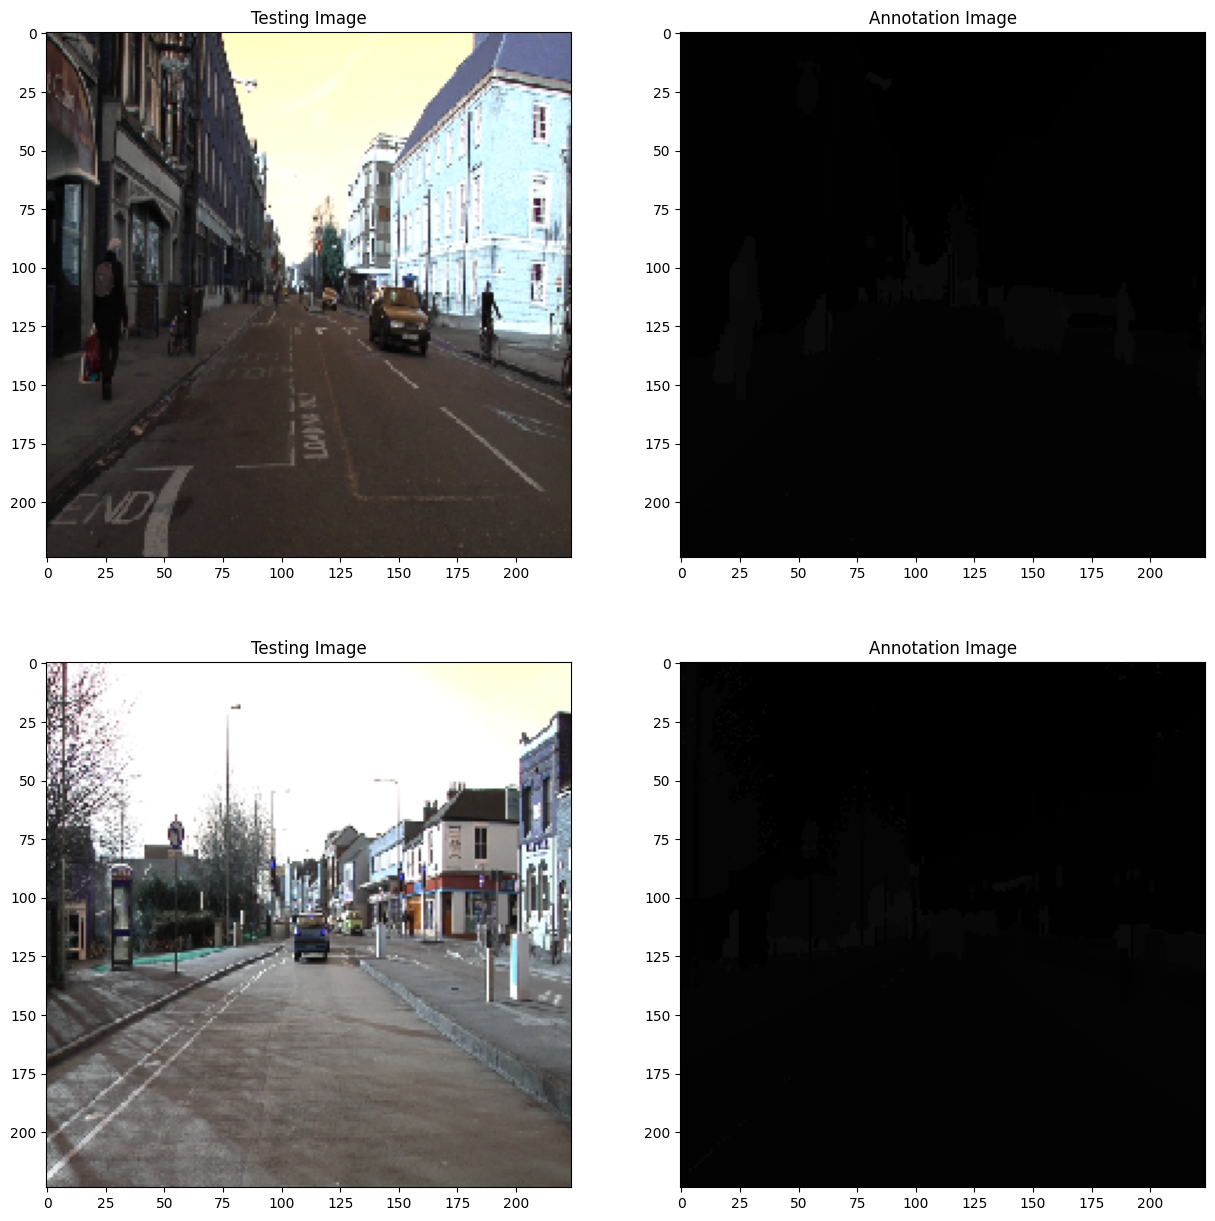

In [8]:
# plot training images
plt.figure(figsize=(15,15))
for i in range(1, 4, 2):
  plt.subplot(2, 2, i)
  plt.imshow(IMAGES_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Testing Image')
  plt.subplot(2, 2, i+1)
  plt.imshow(ANNOTATIONS_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Annotation Image')
plt.show()

In [9]:
# function to get unique values
def get_class(image_y):
  array = image_y.ravel()
  return np.unique(array)

In [10]:
# get information from the dataset
print('image prepped train shape:', IMAGES_TRAIN_ARR.shape)
print('annotations prepped train shape:', ANNOTATIONS_TRAIN_ARR.shape)
print('image prepped test shape:', IMAGES_TEST_ARR.shape)
print('annotations prepped test shape:', ANNOTATIONS_TEST_ARR.shape)
print('data train:', len(IMAGES_TRAIN_ARR))
print('data test:', len(IMAGES_TEST_ARR))

print('\n')
print("unique value of 'annotation'")
print("kind of class :", get_class(ANNOTATIONS_TRAIN_ARR[2]))
print("number of classes:", len(get_class(ANNOTATIONS_TRAIN_ARR[2])))

print('\n')
print("unique value of 'image'")
print("kind of class :\n", get_class(IMAGES_TRAIN_ARR[2]))
print("number of classes:", len(get_class(IMAGES_TRAIN_ARR[2])))

image prepped train shape: (367, 224, 224, 3)
annotations prepped train shape: (367, 224, 224)
image prepped test shape: (101, 224, 224, 3)
annotations prepped test shape: (101, 224, 224)
data train: 367
data test: 101


unique value of 'annotation'
kind of class : [ 0  1  2  3  4  6  7  8  9 10 11]
number of classes: 11


unique value of 'image'
kind of class :
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 1

In [11]:
# Data train
x = np.expand_dims(IMAGES_TRAIN_ARR, axis=3)
train_x_norm = IMAGES_TRAIN_ARR 
train_y_norm = ANNOTATIONS_TRAIN_ARR 

# # Data test
y = np.expand_dims(IMAGES_TEST_ARR, axis=3)
test_x_norm = IMAGES_TEST_ARR 
test_y_norm = ANNOTATIONS_TEST_ARR 

In [12]:
# after normalization data
print('Train images shape:', train_x_norm.shape)
print('Train annots shape:', train_y_norm.shape)
print('Test images shape:', test_x_norm.shape)
print('Test annots shape:', test_y_norm.shape)

Train images shape: (367, 224, 224, 3)
Train annots shape: (367, 224, 224)
Test images shape: (101, 224, 224, 3)
Test annots shape: (101, 224, 224)


In [13]:
# split train data -> train & validation data
train_x, val_x, train_y, val_y = train_test_split(train_x_norm, train_y_norm, test_size=0.1, random_state=14)
print('Train images shape:', train_x.shape)
print('Valid images shape:', val_x.shape)
print('Train annots shape:', train_y.shape)
print('Valid images shape:', val_y.shape)

# test = test_norm
test_x, test_y = test_x_norm, test_y_norm
print('Test annots shape:', test_x.shape)
print('Test images shape:', test_y.shape)

Train images shape: (330, 224, 224, 3)
Valid images shape: (37, 224, 224, 3)
Train annots shape: (330, 224, 224)
Valid images shape: (37, 224, 224)
Test annots shape: (101, 224, 224, 3)
Test images shape: (101, 224, 224)


In [14]:
# num of classes
n_classes = 12

# One Hot Encoding Train Data Annotation
train_y_cat = keras.utils.to_categorical(train_y, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = keras.utils.to_categorical(val_y, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

In [15]:
# after encode annotations dataset
print('Class values in the dataset are:', get_class(train_y[0]))
print('Train images shape', train_x.shape)
print('Train labels shape', train_y_cat.shape)

print('\nClass values in the dataset are:', get_class(val_y[0]))
print('Validation images shape', val_x.shape)
print('Validation labels shape', val_y_cat.shape)

print('\nClass values in the dataset are:', get_class(test_y[0]))
print('Test images shape', test_x.shape)
print('Test labels shape', test_y_cat.shape)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Train images shape (330, 224, 224, 3)
Train labels shape (330, 224, 224, 12)

Class values in the dataset are: [ 1  3  4 11]
Validation images shape (37, 224, 224, 3)
Validation labels shape (37, 224, 224, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test images shape (101, 224, 224, 3)
Test labels shape (101, 224, 224, 12)


Modeling

In [16]:
def FCN8s(image_size, ch_in=3, ch_out=3):
  print(*image_size)
  inputs = Input(shape=(*image_size, ch_in), name='input')

  model_VGG16 = VGG16(weights='imagenet', include_top=False, input_tensor = inputs)

  for layer in model_VGG16.layers:
    layer.trainable = False

  pool3 = model_VGG16.get_layer('block3_pool').output
  pool4 = model_VGG16.get_layer('block4_pool').output
  pool5 = model_VGG16.get_layer('block5_pool').output
  pool5.trainable = True

  conv_pool_3 = Conv2D(filters=9, kernel_size=1, padding='same', activation=None)(pool3)
  conv_pool_4 = Conv2D(filters=9, kernel_size=1, padding='same', activation=None)(pool4)

  conv_inter_1 = Conv2D(filters=1024, kernel_size=1, padding='same', activation=None)(pool5)
  conv_inter_2 = Conv2D(filters=1024, kernel_size=1, padding='same', activation=None)(conv_inter_1)
  conv_pool_5 = Conv2D(filters=9, kernel_size=1, padding='same', activation=None)(conv_inter_2)

  up_x2_1 = Conv2DTranspose(filters=9, kernel_size=4, strides=2, padding='same', activation='relu')(conv_pool_5)
  add_1 = concatenate([up_x2_1, conv_pool_4])
  up_x2_2 = Conv2DTranspose(filters=9, kernel_size=4, strides=2, padding='same', activation='relu')(add_1)
  add_2 = concatenate([up_x2_2, conv_pool_3])
  up_x2_3 = Conv2DTranspose(filters=9, kernel_size=4, strides=8, padding='same', activation='relu')(add_2)
  unit = 12
  outputs = Conv2D(unit, 1, activation='softmax')(up_x2_3)

  model = Model(inputs, outputs)

  return model

In [17]:
model = FCN8s(image_size=(224, 224))
model.summary()

224 224
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 16,312,382 (62.23 MB)

 Trainable params: 1,597,694 (6.09 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
iter = 1
batch_size = 4
epoch = 100

# Checkpoint
MODEL_DIRECTORY = "content/ModelFCN8sResult/"
MODEL_NAME = f'fcn8s_model-{iter}.keras'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.0001, verbose = 1, restore_best_weights = True)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=n_classes)])

# Train model
history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[model_checkpoint, early_stopping])
#history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.3176 - loss: 2.4003 - mean_io_u_1: 0.3436 - val_accuracy: 0.3223 - val_loss: 2.3072 - val_mean_io_u_1: 0.4537
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3405 - loss: 2.2914 - mean_io_u_1: 0.3476 - val_accuracy: 0.3254 - val_loss: 2.2388 - val_mean_io_u_1: 0.4538
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3469 - loss: 2.2207 - mean_io_u_1: 0.3474 - val_accuracy: 0.3295 - val_loss: 2.1782 - val_mean_io_u_1: 0.4526
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3444 - loss: 2.1660 - mean_io_u_1: 0.3466 - val_accuracy: 0.3333 - val_loss: 2.1250 - val_mean_io_u_1: 0.4537
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3519 - loss: 2.1150 - mean_io_u_1: 0.3469 - val_accuracy: 0.3347 - val_loss: 2.0806 - val_mean_io_u_1: 0.4521
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3542 - loss: 2.0706 - mean_io_u_1: 0.3449 - val_accu

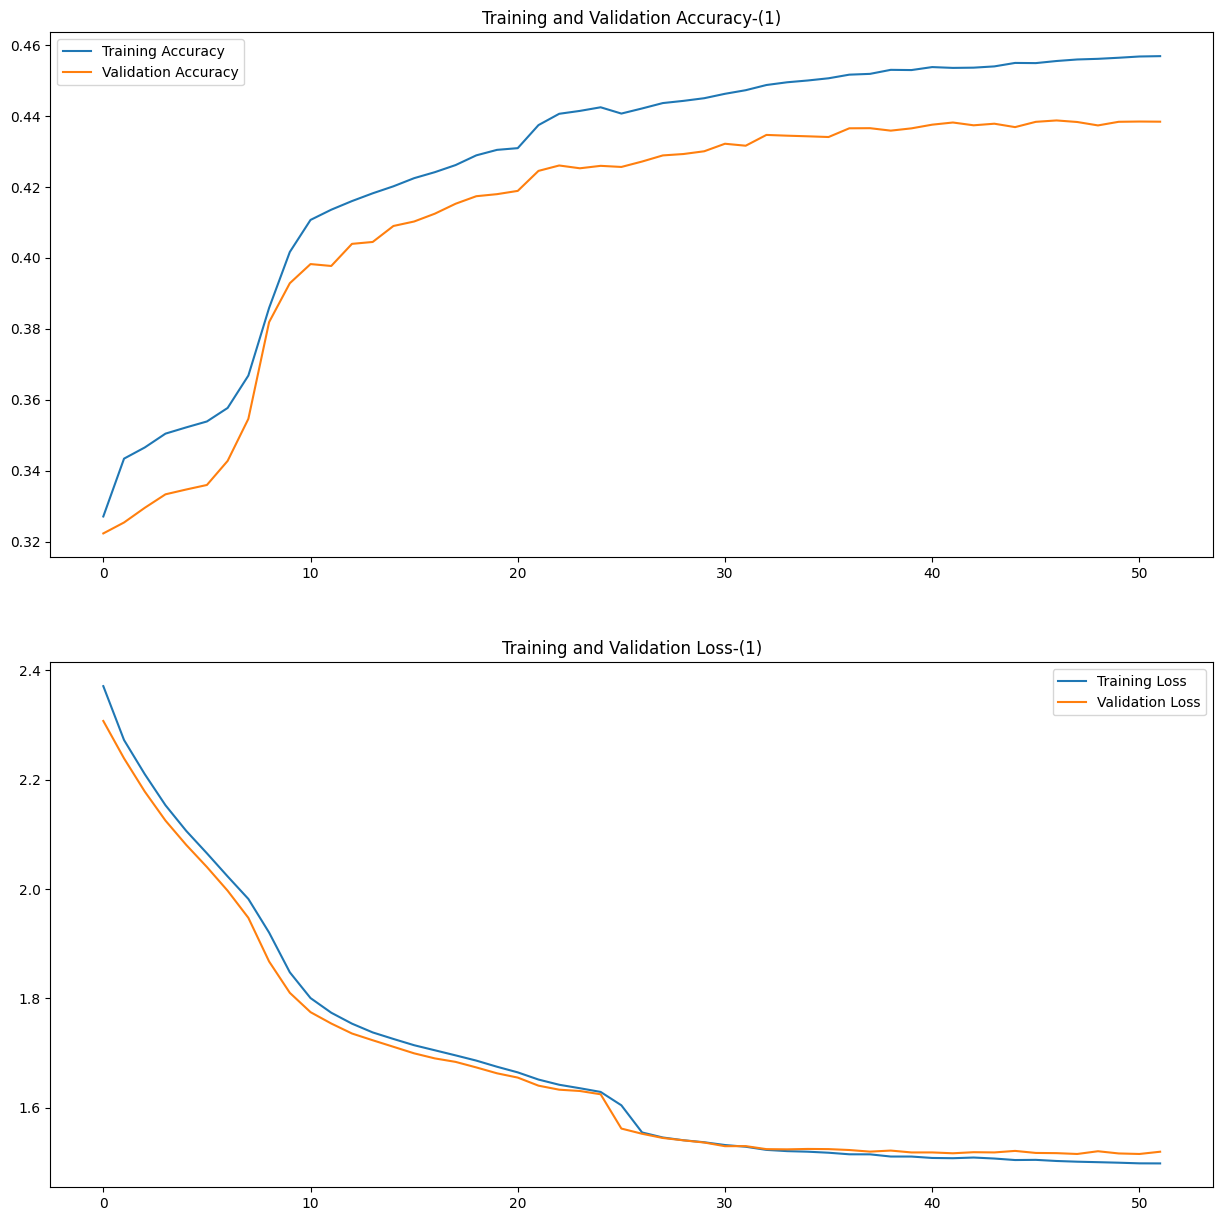

In [20]:
# Plot training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy-({iter})')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')

plt.title(f'Training and Validation Loss-({iter})')

# save figure
#PATH_FIGURE = "drive/MyDrive/Colab Notebooks/CVProject3/ModelFCN8sResult/Figures/"
#plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(PATH_FIGURE))
#print('saving figure to:')
#plt.savefig(f"Training and validation-{iter}.png")

plt.show()

In [21]:
# View the models stored in the model directory
MODEL_DIRECTORY = "content/ModelFCN8sResult/"
MODEL_LISTDIR = os.listdir(MODEL_DIRECTORY)
MODEL_LISTDIR

['.ipynb_checkpoints', 'fcn8s_model-1.keras']

In [23]:
# load the model and weight
LOADMODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_LISTDIR[1])
load_model = keras.models.load_model(LOADMODEL_PATH)
print('Loaded trained model at %s' %LOADMODEL_PATH)

Loaded trained model at content/ModelFCN8sResult/fcn8s_model-1.keras


In [24]:
# Evaluate the model with the same amount of validation data
# test_x_norm[:37], test_y_cat[:37]
score = load_model.evaluate(test_x[:10], test_y_cat[:10], verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test Mean IOU:", score[2])
score

Test loss: 1.6269912719726562
Test accuracy: 0.4386260509490967
Test Mean IOU: 0.4583558440208435


[1.6269912719726562, 0.4386260509490967, 0.4583558440208435]

In [31]:
# give color annotation img
def give_color_to_annotation_img(img):
  random_colors = []

  for i in range(5000):
    random.seed(i)
    randColor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    random_colors.append(randColor)

  img_zeros = np.zeros((224, 224, 3))
  for j in range(n_classes):
    img_zeros[:, :, 0] += ((img[:, :, 0] == j)*(random_colors[j][0])).astype('uint8')
    img_zeros[:, :, 1] += ((img[:, :, 0] == j)*(random_colors[j][1])).astype('uint8')
    img_zeros[:, :, 2] += ((img[:, :, 0] == j)*(random_colors[j][2])).astype('uint8')

  img_zeros = cv2.cvtColor(np.array(img_zeros, dtype=np.uint8), cv2.COLOR_BGR2RGB)
  return img_zeros

# plot grayscale img
def plot_img(input_img, title='', iter=0):
  N_ch = input_img.shape[2]
  if N_ch == 1:
    plt.imshow(input_img[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title(title + f' {[iter]}')
  elif N_ch == 3:
    plt.imshow(input_img)
    plt.title(title + f' {[iter]}')
  else:
    print('error image')
    return
  # set the spacing between subplots
  plt.subplots_adjust(bottom=0.1, top=0.5)

# invert encoding (to_categorical) to original data
def invert_from_cat(img_cat):
  inverted = tf.keras.backend.argmax(img_cat)
  inverted_1dims = np.expand_dims(inverted, axis=2)
  return inverted_1dims

# preprocessing to predict
def prepare(filename):
  IMAGE_CHANNEL = 3
  IMG_SIZE = 224
  new_array = cv2.resize(filename, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

# IoU of Each Class
def get_IoU_of_class(annota_img, pred_img):
  from keras.metrics import MeanIoU
  val,sum3 = 0,0
  IoU_arr = []
  IoU_keras = MeanIoU(num_classes=n_classes)
  IoU_keras.update_state(annota_img, pred_img)
  values = np.array(IoU_keras).reshape(n_classes, n_classes)
  print("IoU of Each Class:")
  for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    for k in range(n_classes):
        if k != i:
            sum2 = values[k, i] + sum2
        else:
            continue
    sum3 = sum1 + sum2
    IoU_arr.append(val/sum3)
    print(f"IoU Class {i}: {val/sum3*100:.2f}%")
  print(f"Mean IoU: {IoU_keras.result().numpy()*100:.2f}%")

  plt.figure(figsize=(8, 5))
  plt.bar(np.arange(0, len(IoU_arr)), IoU_arr)
  plt.xticks(np.arange(0, len(IoU_arr)))
  plt.ylabel("IoU")
  plt.xlabel("Class")
  plt.title("IoU of Each Class")

# Function to predict
# input: 1 image from test_x & test_y_cat
def predict_annotation(img_x, img_y, iter=0):
  # inverse from normalize data
  grayscale_img = img_x*255*255

  # predict image
  prediction = load_model.predict([prepare(img_x)])
  prediction_reshape = prediction.reshape((224, 224, 12)) # test_y_cat[0].shape

  # invert predict from categorical
  pred_invert = invert_from_cat(prediction_reshape)
  annota_img = invert_from_cat(img_y)

  # give color to pred_invert image
  colored_img = give_color_to_annotation_img(annota_img)
  colored_pred = give_color_to_annotation_img(pred_invert)

  # masked image
  grayscale_img3ch = np.zeros((224, 224, 3))
  #grayscale_img3ch = grayscale_img3ch #np.expand_dims(grayscale_img3ch, axis=3)

  #grayscale_img3ch[:,:,0] += grayscale_img
  #grayscale_img3ch[:,:,1] += grayscale_img
  #grayscale_img3ch[:,:,2] += grayscale_img
  grayscale_img3ch2 = grayscale_img3ch.reshape(grayscale_img3ch.shape[0],grayscale_img3ch.shape[1], grayscale_img3ch.shape[2])
  masked_image = cv2.addWeighted(np.array(grayscale_img3ch2, dtype=np.uint8), 0.5, np.array(colored_pred, dtype=np.uint8), 0.5, 0)

  # plot image
  img_arr = [grayscale_img, annota_img, colored_img, pred_invert, colored_pred, masked_image]
  title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']
  plt.figure(figsize=(20,20))
  for i in range(len(img_arr)):
    plt.subplot(int(len(img_arr)/3), int(len(img_arr)/2), i+1)
    plot_img(img_arr[i], title_arr[i], iter)

  # save figure
  PATH_FIGURE = "content/ModelFCN8sResult/PredictionImage/"
  #dir_name = os.path.join(GDRIVE_PATH, PATH_FIGURE)
  #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(PATH_FIGURE))
  plt.savefig(f"PredictionResult-{iter}.png")
  print(f'saving figure to: {PATH_FIGURE}\n')

  # plot figure
  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
saving figure to: content/ModelFCN8sResult/PredictionImage/



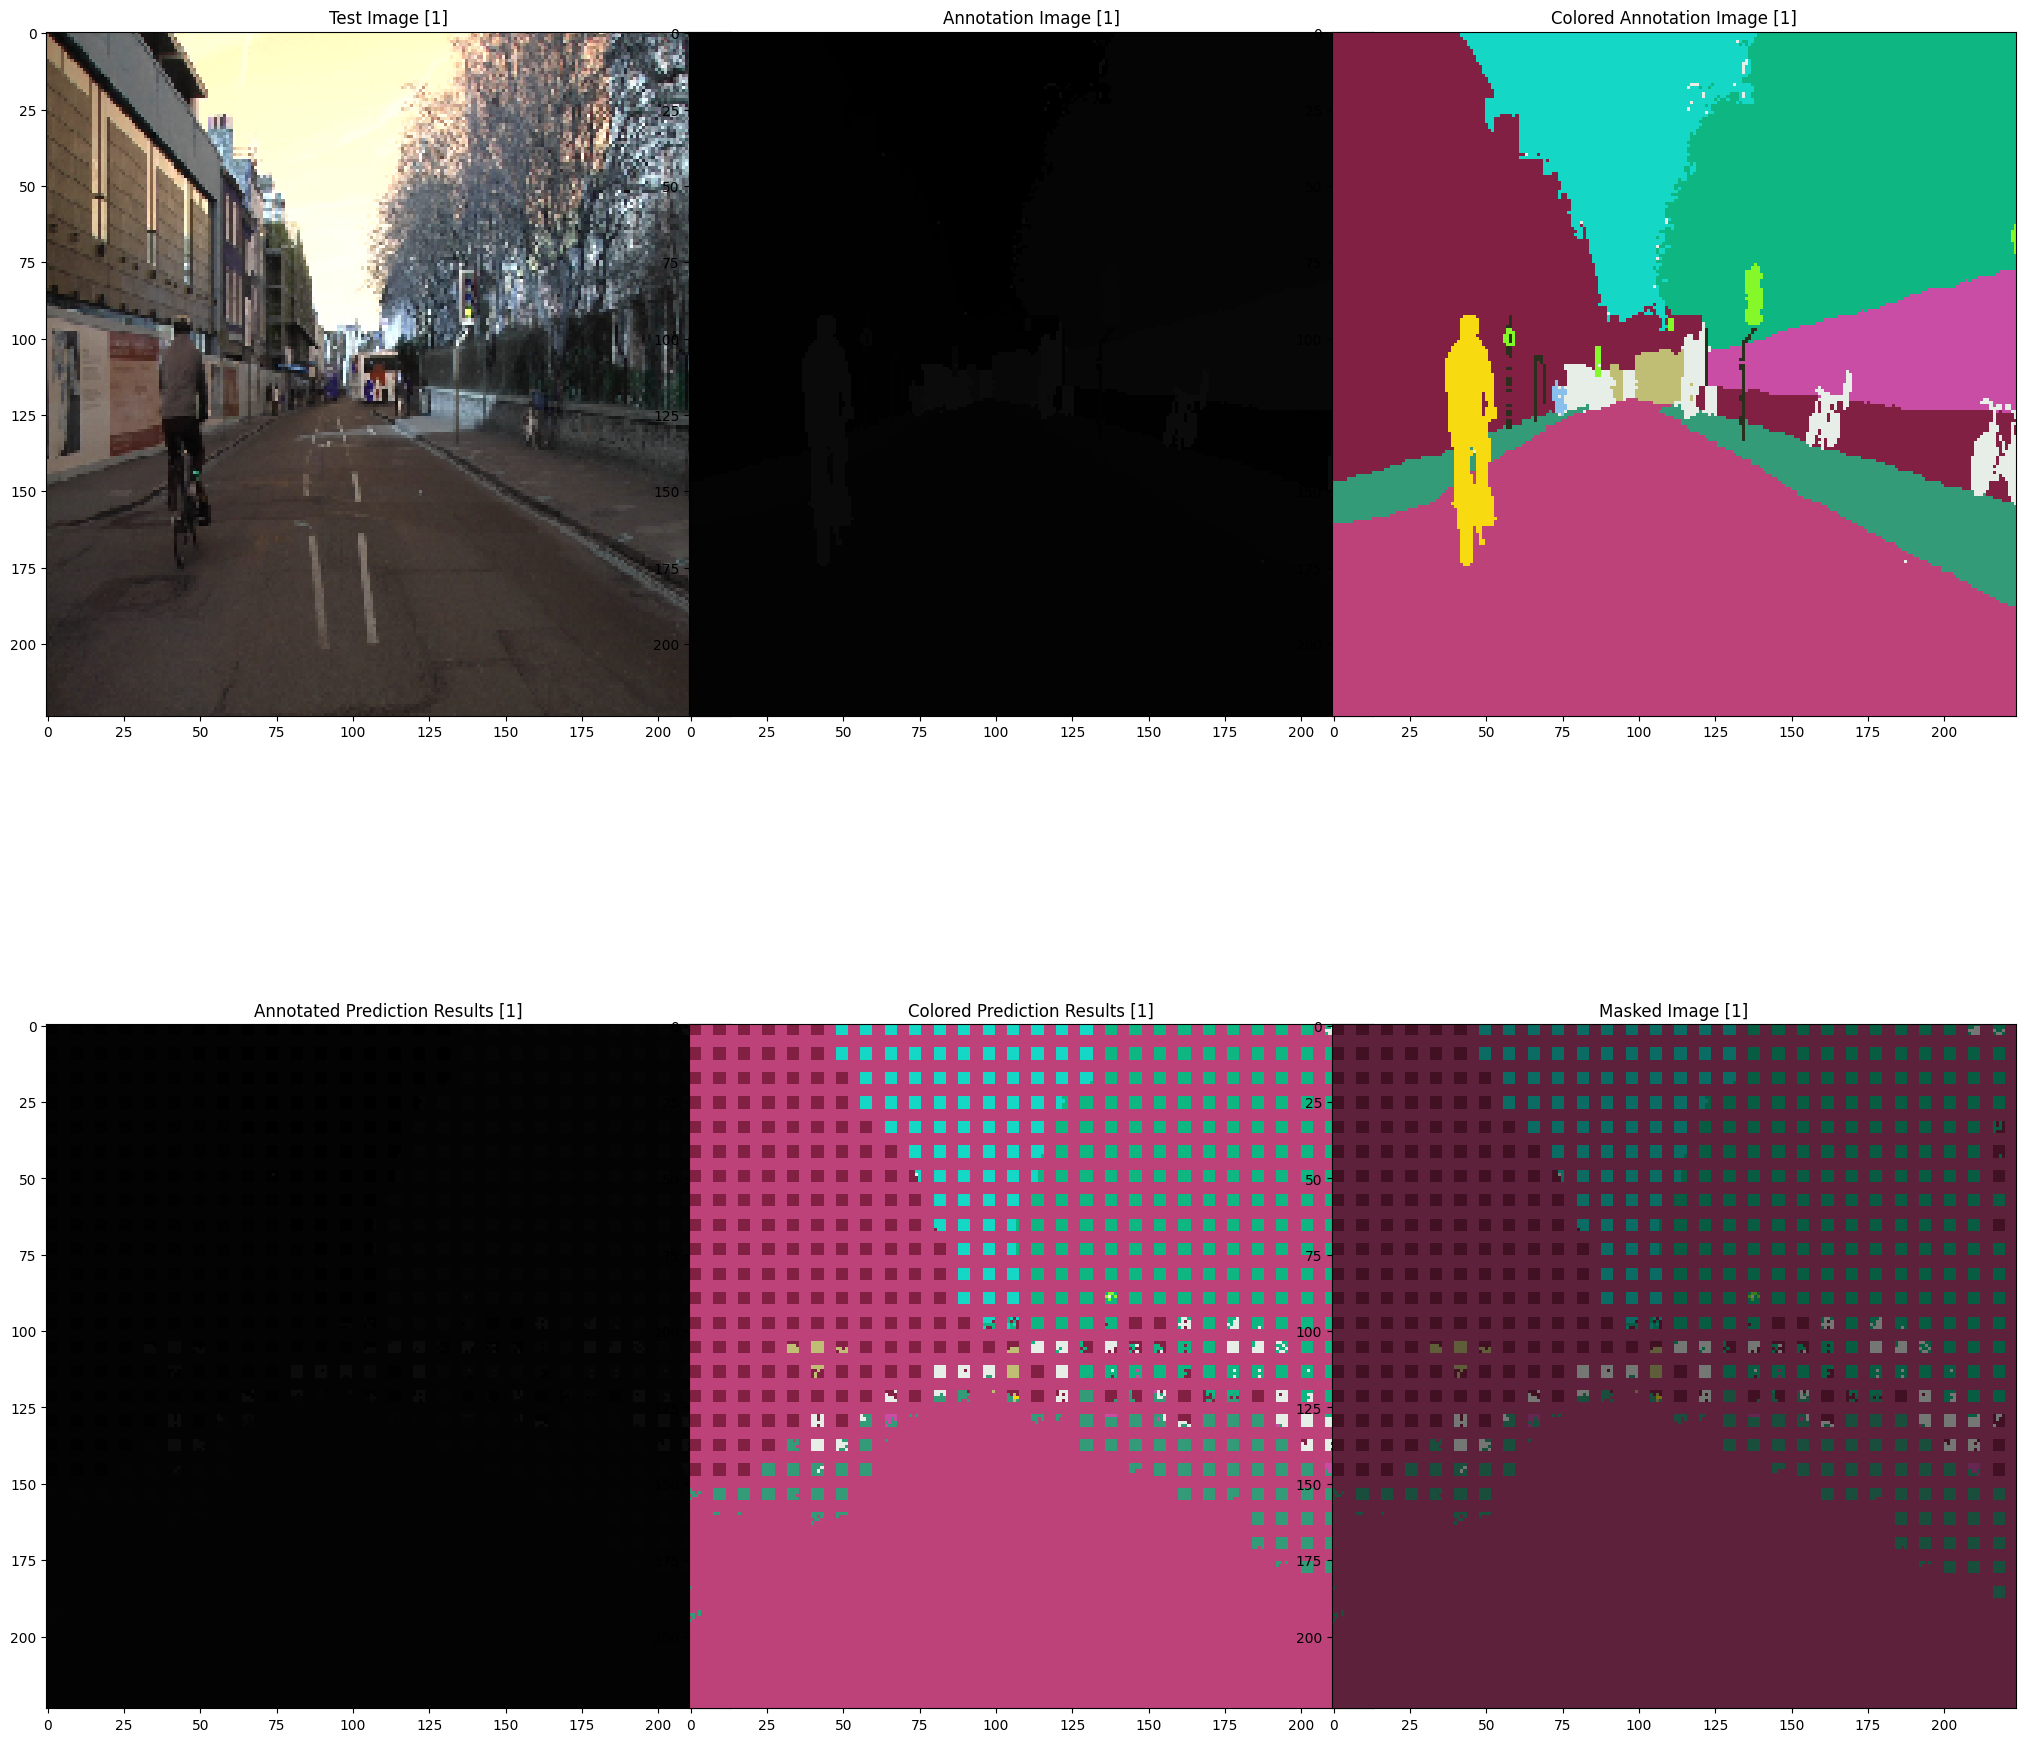

In [32]:
# testing the function
predict_annotation(test_x[0], test_y_cat[0], 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
saving figure to: content/ModelFCN8sResult/PredictionImage/



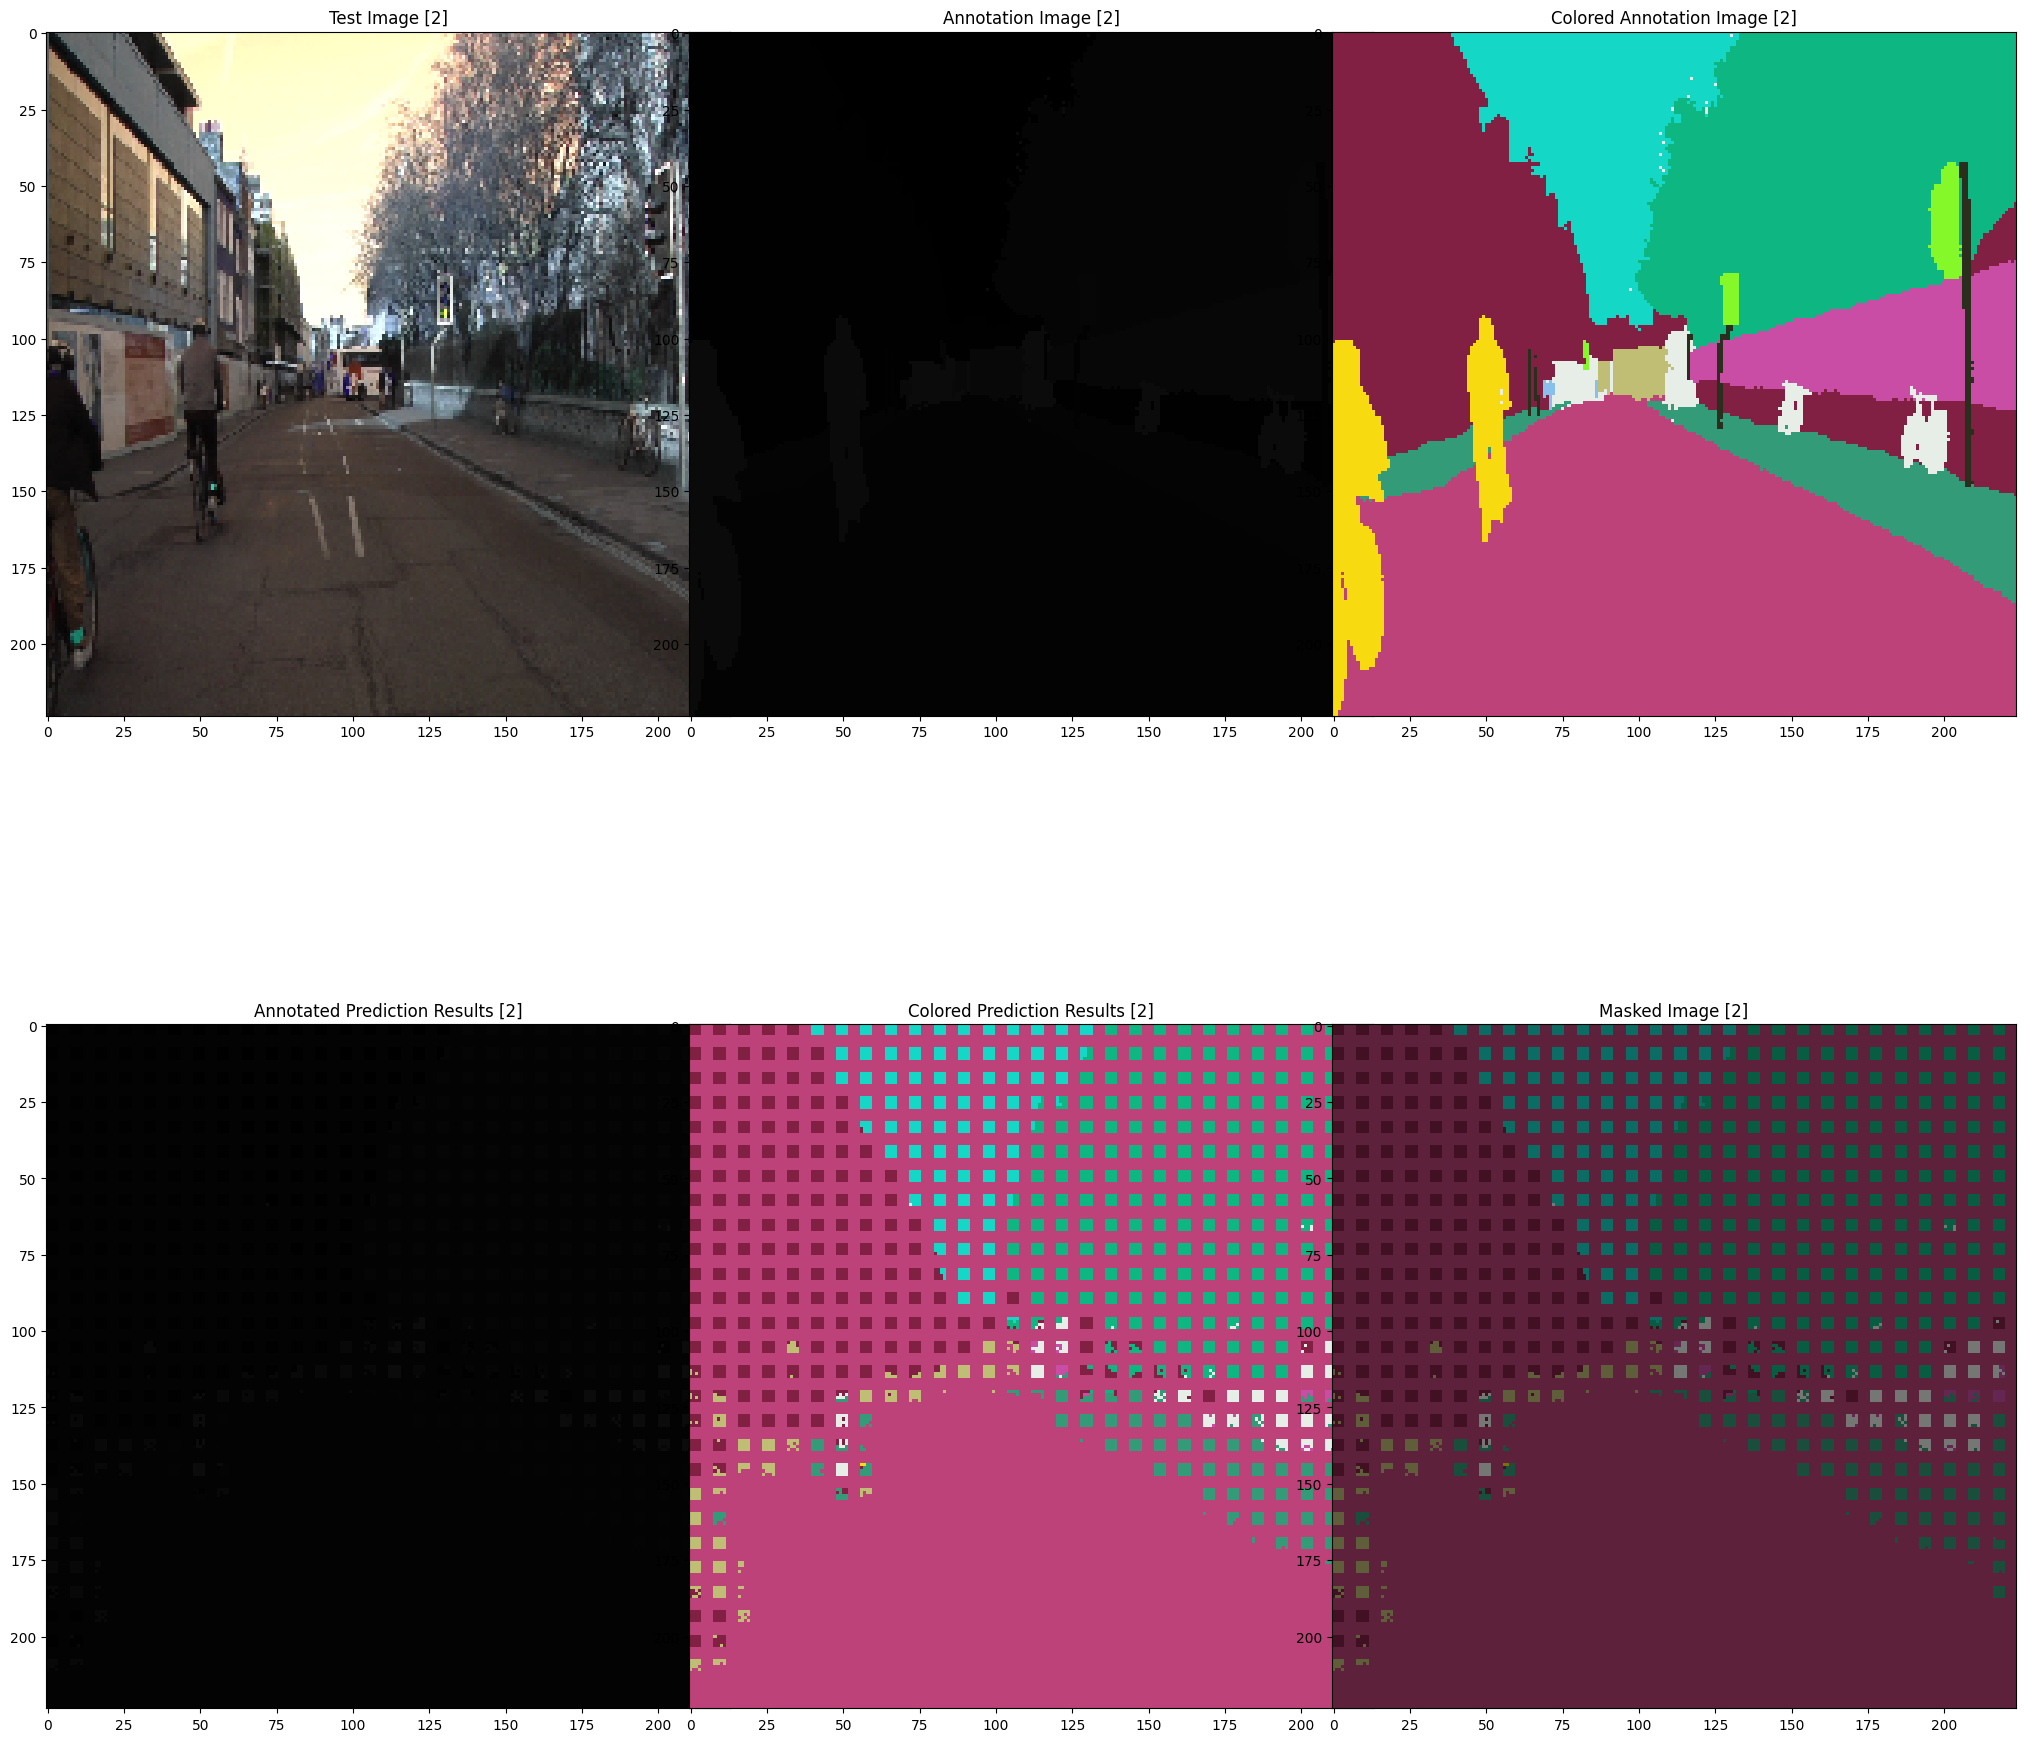

In [33]:
# testing the function
predict_annotation(test_x[1], test_y_cat[1], 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
saving figure to: content/ModelFCN8sResult/PredictionImage/



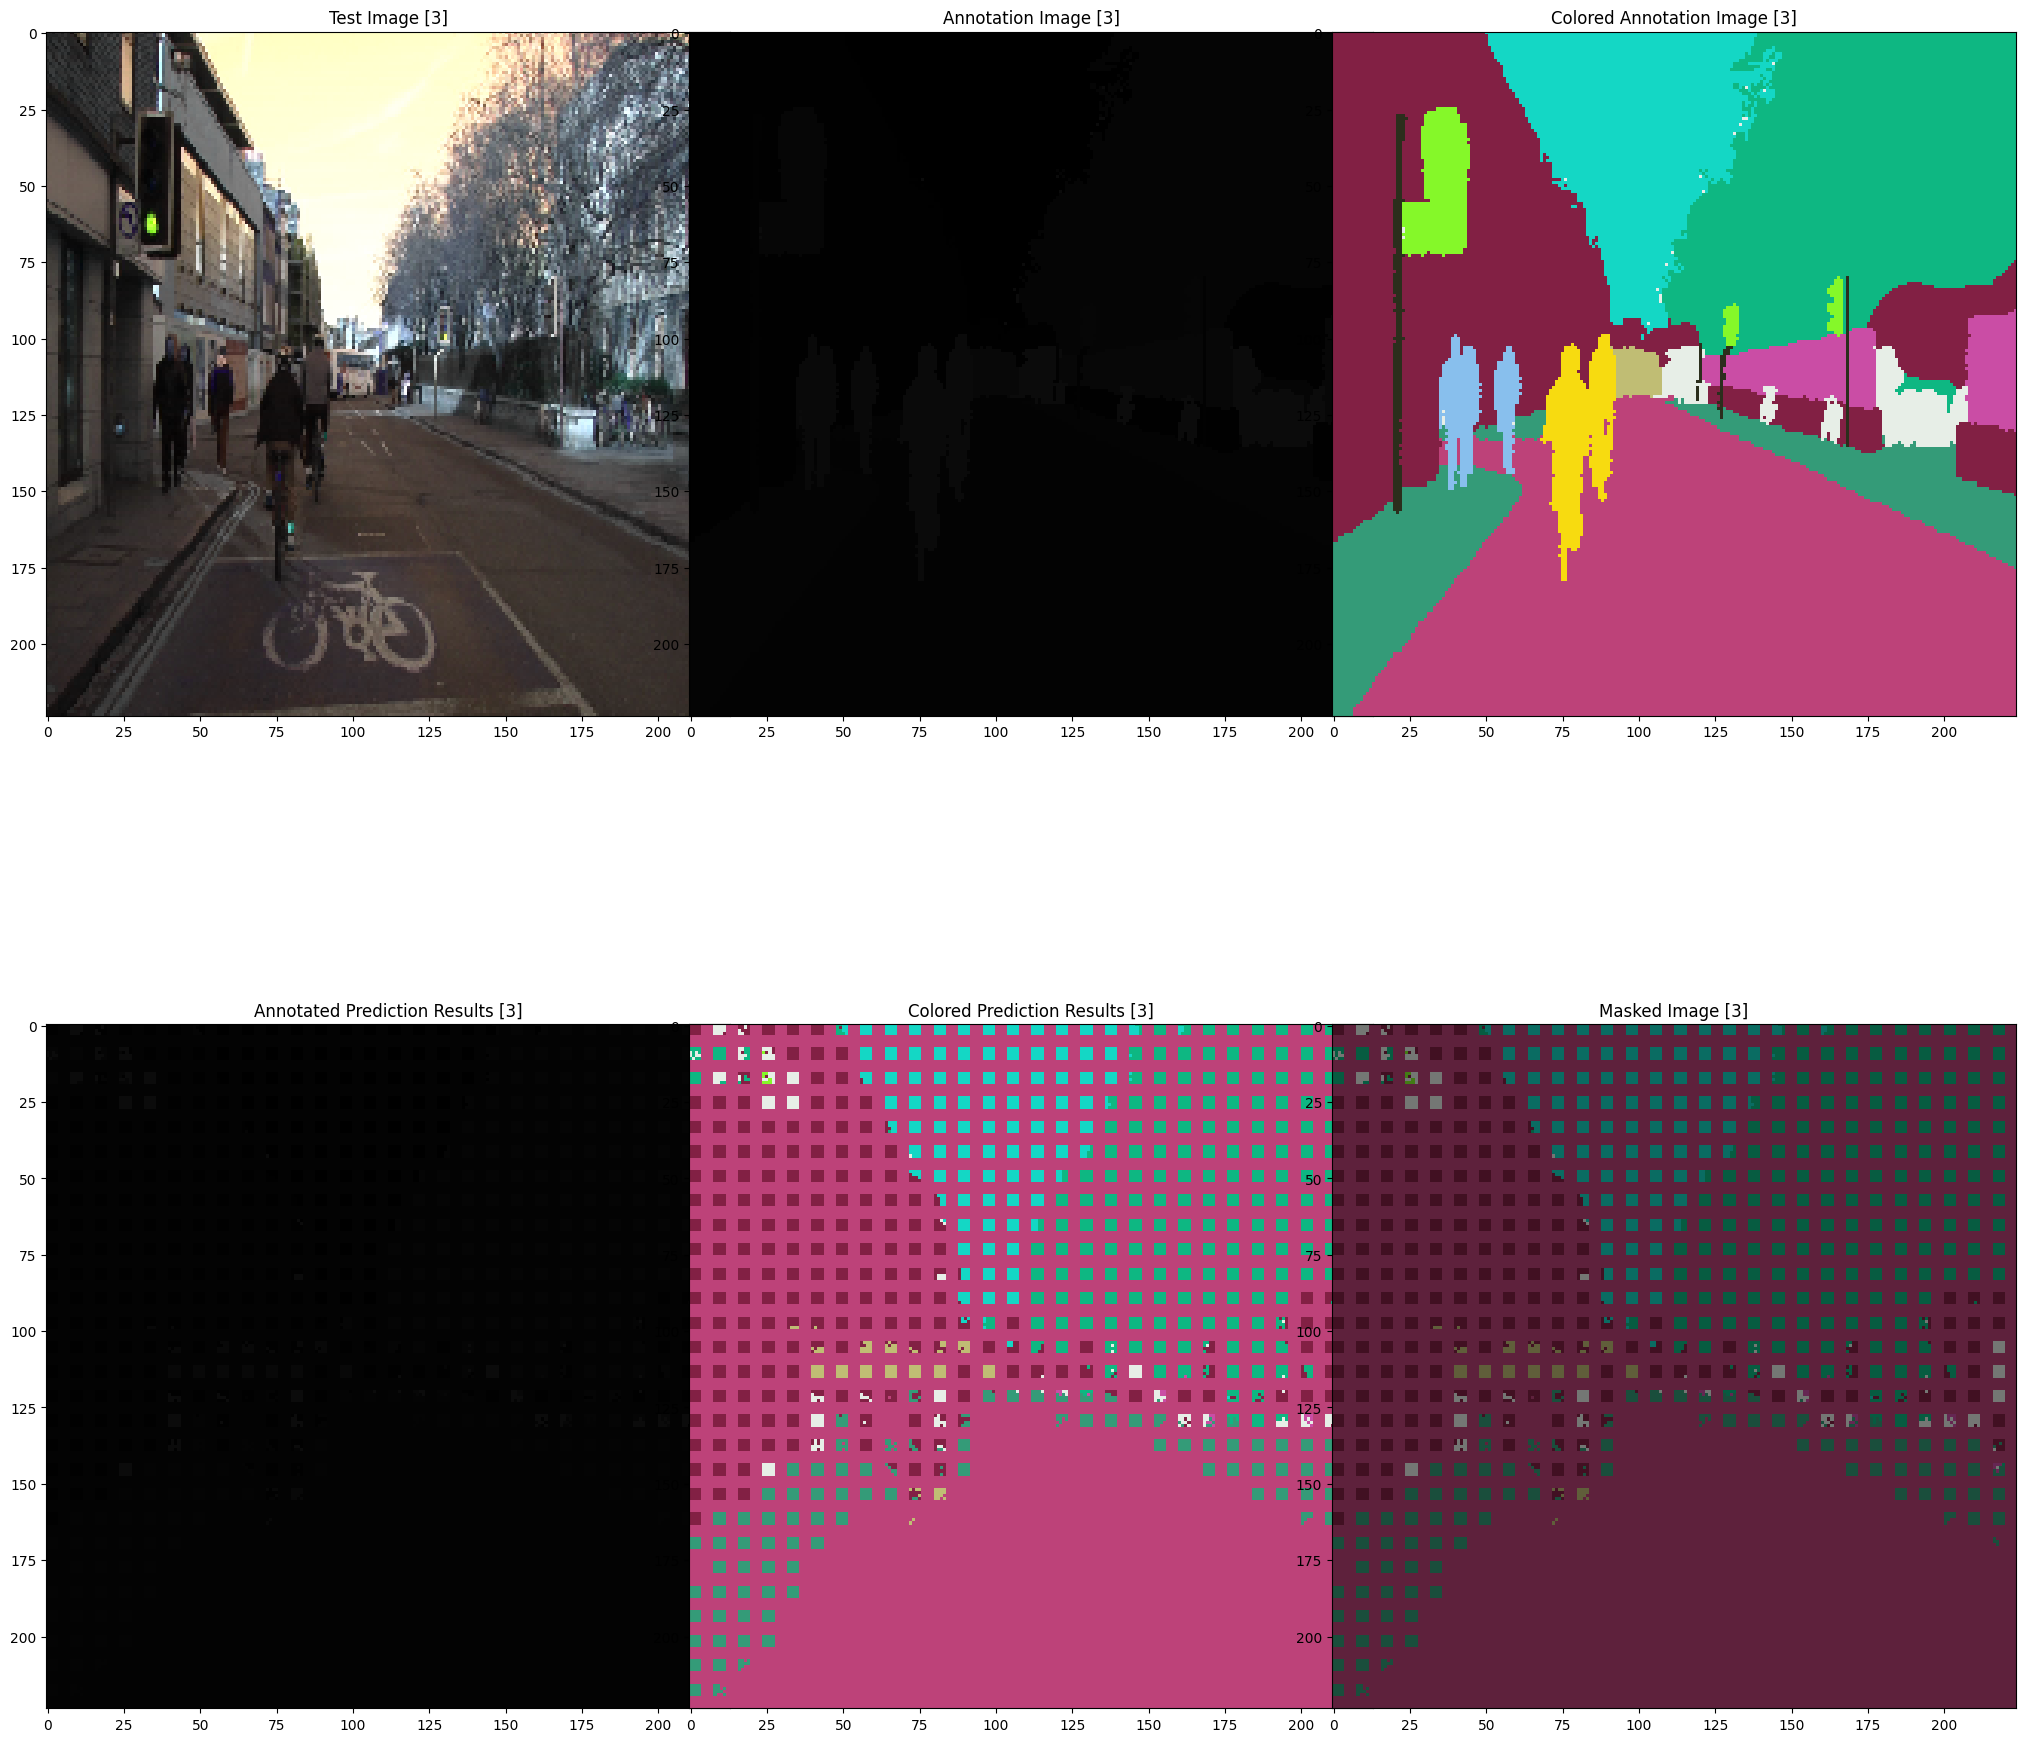

In [34]:
# testing the function
predict_annotation(test_x[2], test_y_cat[2], 3)